In [27]:
#!/usr/bin/env python3
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import time

import tensorflow as tf

from src.architecture import FootpathModelArchitecture
from src.miscellaneous import load_random_image, preprocess_image, save_predicted_mask
from src.visualization import create_overlay, display_images

## Load and prepare parameters

In [2]:
parameter_directory = './parameters/'
parameter_file = 'testing.json'
parameter_path = parameter_directory + parameter_file

In [3]:
with open(parameter_path) as parameter_file:
    parameters = json.load(parameter_file)

In [4]:
model_parameters = parameters['model']
test_data_parameters = parameters['test_data']
output_parameters = parameters['output']

## Build the model structure

In [5]:
image_parameters = test_data_parameters['image_dimensions']
input_width = image_parameters['width']
input_height = image_parameters['height']
image_dimensions = (input_width, input_height)
input_shape = (input_width, input_height, 3)

In [6]:
footpath_model = FootpathModelArchitecture(input_shape).footpath_model

## Load weights

In [7]:
model_directory = model_parameters['root_directory']

In [8]:
model_file = model_parameters['model_file_name']

In [9]:
footpath_model.load_weights(model_directory + model_file)

## Visualize predictions of the model and measure how long it takes to predict a mask.

In [37]:
def visualize_predictions_preprocessing(test_data_directory, number_of_examples,
                                        measure_inference_time=False, measure_overall_time=False):
    
    test_image_names = os.listdir(test_data_directory)
    
    for i in range(number_of_examples):
        if (measure_overall_time):
            overall_start_time = time.time()
        
        test_image = load_random_image(test_data_directory, image_dimension=image_dimensions)
        preprocessed_image = preprocess_image(test_image, expand_dimension=True)

        if (measure_inference_time):
            start_time = time.time()
            predicted_mask = footpath_model.predict(preprocessed_image)
            end_time = time.time()
        else:
            predicted_mask = footpath_model.predict(preprocessed_image)

        predicted_mask = predicted_mask > 0.5
        overlay = create_overlay(test_image, predicted_mask, alpha=0.3, from_prediction=True)
        display_images([test_image, predicted_mask, overlay], ['origin', 'predicted_mask', 'overlay'])
        
        if (measure_inference_time):
            print("Inference time: ", round(end_time-start_time, 2))
        if (measure_overall_time):
            overall_end_time = time.time()
            print("Overall time: ", round(overall_end_time-overall_start_time, 2))

In [38]:
test_data_directory = test_data_parameters['test_data_directory']

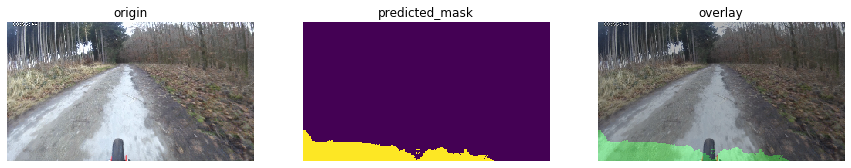

Inference time:  1.4
Overall time:  1.85


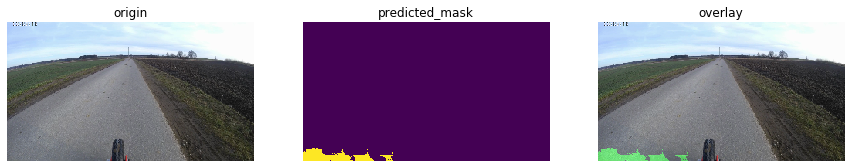

Inference time:  1.38
Overall time:  1.81


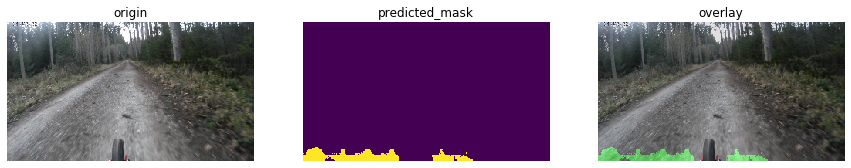

Inference time:  1.49
Overall time:  1.95


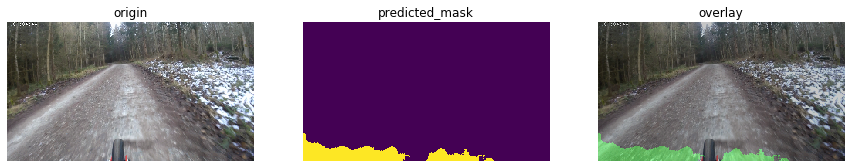

Inference time:  1.33
Overall time:  1.78


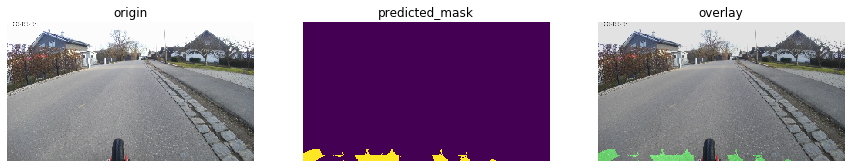

Inference time:  1.41
Overall time:  1.84


In [39]:
visualize_predictions_preprocessing(test_data_directory, 5, True, True)

In [40]:
def process_dataset_content(image_path, image_dimensions):
    image = tf.io.read_file(filename=image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, image_dimensions)
    image = tf.expand_dims(image, 0)
    return image

In [41]:
def visualize_predictions_dataset(test_data_directory, number_of_examples, image_dimensions=image_dimensions, 
                                  measure_inference_time=False, measure_overall_time=False):
    
    test_image_dataset = tf.data.Dataset.list_files(test_data_directory + '*')
    test_image_dataset = test_image_dataset.map(lambda image_path: process_dataset_content(image_path,
                                                                                           image_dimensions))
        
    for test_image in test_image_dataset.take(number_of_examples):
        if (measure_overall_time):
            overall_start_time = time.time()
        
        if (measure_inference_time):
            inference_start_time = time.time()
            predicted_mask = footpath_model.predict(test_image)
            inference_end_time = time.time()
        else:
            predicted_mask = footpath_model.predict(test_image)

        predicted_mask = predicted_mask > 0.5
        overlay = create_overlay(test_image, predicted_mask, alpha=0.3, from_prediction=True)
        display_images([test_image, predicted_mask, overlay], ['origin', 'predicted_mask', 'overlay'])
        
        if (measure_inference_time):
            print("Inference time: ", round(inference_end_time-inference_start_time, 2))
        if (measure_overall_time):
            overall_end_time = time.time()
            print("Overall time: ", round(overall_end_time-overall_start_time, 2))


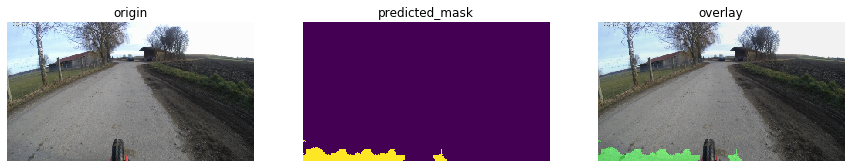

Inference time:  1.24
Overall time:  1.63


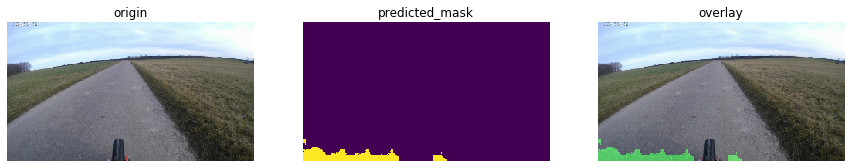

Inference time:  1.4
Overall time:  1.8


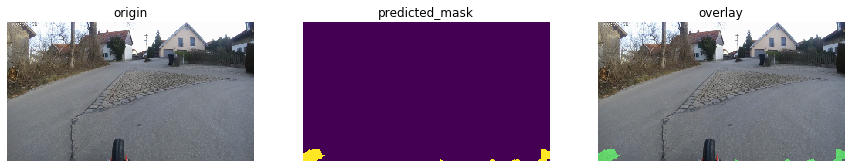

Inference time:  1.39
Overall time:  1.95


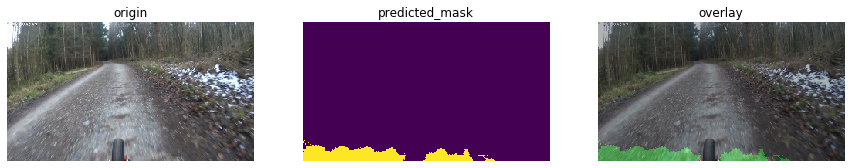

Inference time:  1.33
Overall time:  1.72


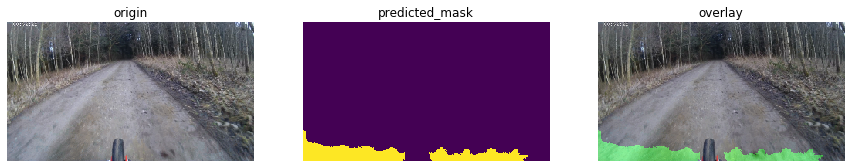

Inference time:  1.36
Overall time:  1.76


In [42]:
visualize_predictions_dataset(test_data_directory=test_data_directory,
                              number_of_examples=5,
                              measure_inference_time=True,
                              measure_overall_time=True)